# Trabajo Práctico Final - Control Digital

## Armado y Análisis Teórico
La _planta_ bajo estudio en el presente trabajo consta de un circuito RC-RC 
similar en estructura al sugerido por la cátedra. Sin embargo, por cuestiones
de disponibilidad, se han variado levemente los valores de los componentes.
Los valores utilizados y el análisis inicial del sistema se muestra a 
continuación.

Polo 0: 362.997Hz
Polo 1: 34.891Hz


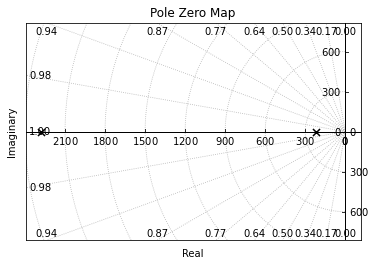

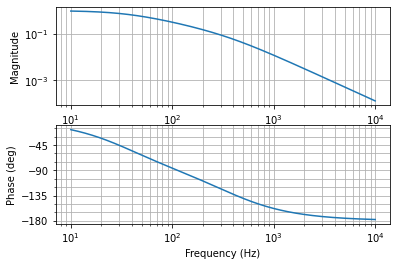

In [7]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt

# Componentes
r_1, c_1, r_2, c_2 = 10e3, 100e-9, 10e3, 200e-9

# Transferencia teórica
s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)

# Polos
for i, pole_hz in enumerate(poles(hs_1) / (2*np.pi)):
    print(f'Polo {i}: {float(-pole_hz.real):.3f}Hz')

# Mapa de Polos - Notar que está en Rad/s
pzmap(hs_1, grid=True )
plt.show()

# Diagrama de Bode
bode(hs_1, Hz=True)


(array([0.80314212+0.j, 0.10220482+0.j]), array([-0.44487251+0.j]))

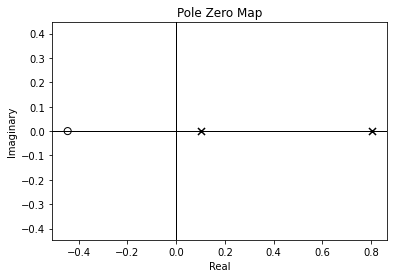

In [8]:
# Análisis Discretizado
SR_F_HZ = 1000

hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
pzmap(hz_1)

## Análisis en Planta
El análisis en planta consiste en evaluar el comportamiento del sistema ante
una señal cuadrada de 10Hz, a fines de caracterizar su rise time y comparar
su desempeño con el modelo teório presentado.

Para ello se utilizó [este](../src/step_response_app.c) programa. Cabe destacar
que para facilitar la visualización de desarrolló una [biblioteca C](../inc/data_publisher.h)
y un [script en Python](../scripts/datavis.py) para poder visualizar en tiempo
real (y recolectar los datos) de las señales de entrada y salida.

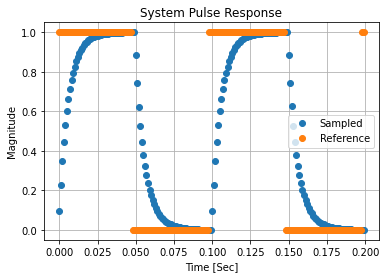

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10
SAMPLES_PER_PERIOD = SR_F_HZ // SQ_WAVE_F_HZ

# Cargamos los datos.
data = pd.read_csv('out/step_resp.csv')

# Acotamos entre -1 y 1 los valores leídos.
for label in ('Data', 'Reference'):
    data[label] -= data[label][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].min()  # OG Data contains values < 0.
    data[label] /= data[label][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].max()

# Acomodamos los datos para que los datos "comiencen" al principio de la señal
# cuadrada.
data = data.tail(-data[data['Data'].diff().gt(0.1)].index[0]+1).reset_index(drop=True)

# Agregamos un vector de tiempo.
data['Time'] = np.arange(len(data)) / SR_F_HZ

# Ploteamos dos ciclos.
plt.plot(data['Time'][:SAMPLES_PER_PERIOD * 2], data['Data'][:SAMPLES_PER_PERIOD * 2], 'o', label='Sampled')
plt.plot(data['Time'][:SAMPLES_PER_PERIOD * 2], data['Reference'][:SAMPLES_PER_PERIOD * 2], 'o', label='Reference')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()
plt.grid()

t_r = 13.0 ms


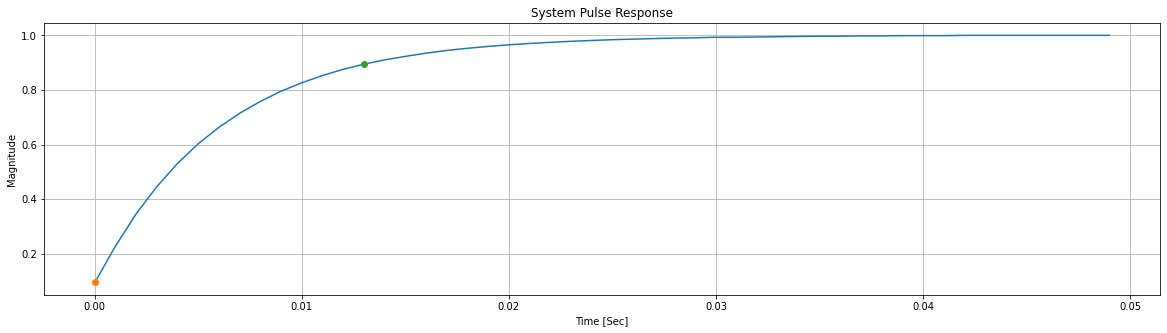

In [16]:
# Calculamos los límites para el risetime.
v10 = (data['Data'].max())*.1
v90 = (data['Data'].max())*.9

# Buscamos los instantes en los que ocurren.
t10_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v10).abs().argmin()
t90_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v90).abs().argmin()

# Graficamos.
plt.figure(figsize=(20, 5))
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)])
plt.plot(data['Time'][t10_i], data['Data'][t10_i], 'o')
plt.plot(data['Time'][t90_i], data['Data'][t90_i], 'o')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

# Calculamos el Risetime.
tr = abs(data['Time'][t90_i] - data['Time'][t10_i])
print(f't_r = {tr * 1000} ms')

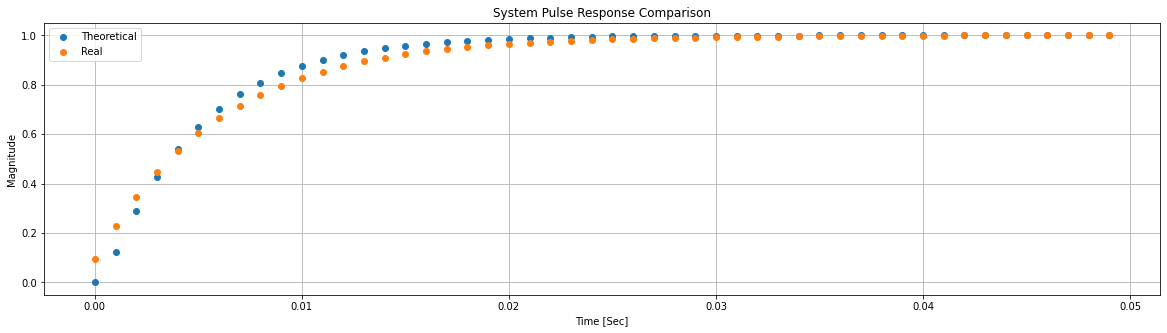

In [17]:
# Comparamos la respuesta al escalón obtenida con el modelo discretizado
t, hz_out = step_response(hz_1)
plt.figure(figsize=(20, 5))
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], hz_out[:SR_F_HZ//SQ_WAVE_F_HZ//2], 'o', label='Theoretical')
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o', label='Real')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

# Identificación del Sistema
Para identificar el sistema se ha adaptado el programa propuesto en clase 
para la CIAA, a partir del cual se ha desarrollado una [aplicación de identificación](../src/identification_app.c).
Utiliza el algoritmo de LS junto a la biblioteca ya mencionada para transferir
datos a la PC.

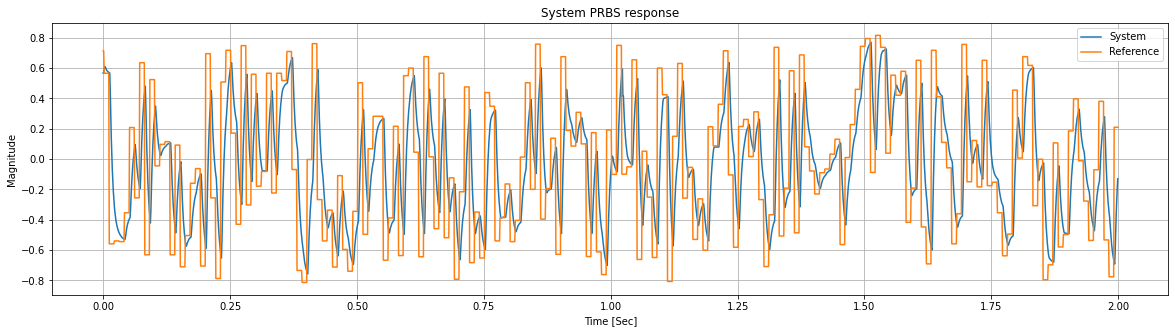

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000

# Datos capturados de la respuesta del sistema a la señal PRBS.
data2 = pd.read_csv('out/prbs_resp2.csv')
data2['Data'].replace(0.0, float('nan'), inplace=True)
data2.fillna(method='bfill', inplace=True)
data2['Time'] = np.arange(len(data2)) / SR_F_HZ
plt.figure(figsize=(20, 5))
plt.plot(data2[:2000]['Time'], data2[:2000]['Data'], label='System')
plt.plot(data2[:2000]['Time'], data2[:2000]['Reference'], label='Reference')
plt.grid()
plt.title('System PRBS response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

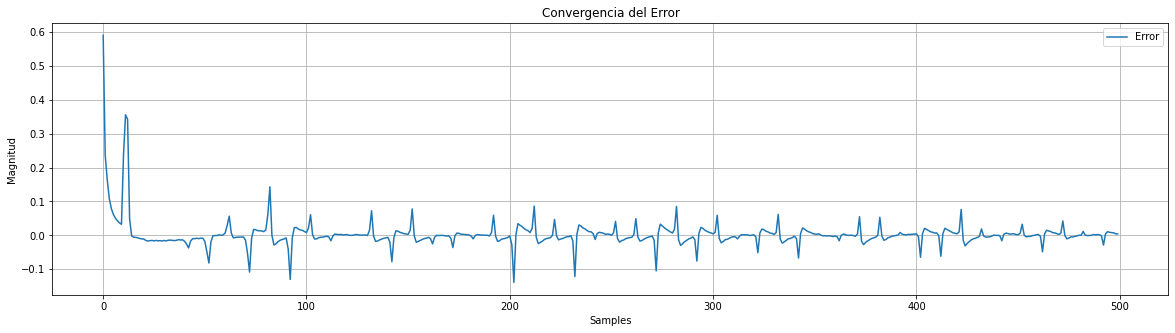

In [23]:
import numpy as np

# Identificación RLS complementaria en Python, utilizando los datos recolectados
# de la planta.
order = 2
def identificacionRLS(n, u, y, lastP, lastTheta):
    Phi = np.asmatrix(np.concatenate((y[::-1][1:n+1], u[::-1][:n+1])))
    p = lastP - np.dot(np.dot(lastP, Phi.T), Phi.dot(lastP))/(1 + np.dot(np.dot(Phi, lastP), Phi.T))
    k = np.dot(lastP, Phi.T)/(1 + np.dot(np.dot(Phi, lastP), Phi.T))
    error = (np.asmatrix(y[-1]) - np.dot(Phi, lastTheta))[0, 0]
    aux = error * k 
    theta = lastTheta + np.asmatrix(aux)
    return theta, p, error 

Theta = np.zeros((2*order+1, 1))
P = np.eye(2*order+1)

toterr = []
for i in range(order, len(data['Data'])):
    Theta, P, error = identificacionRLS(order, np.array(data2['Reference'][i-order:i+1]), np.array(data2['Data'][i-order:i+1]), P, Theta)
    toterr.append(error)

# Observamos la convergencia del error.
plt.figure(figsize=(20, 5))
plt.plot(toterr[:500], label='Error')
plt.grid()
plt.title('Convergencia del Error')
plt.ylabel('Magnitud')
plt.xlabel('Samples')
plt.legend()


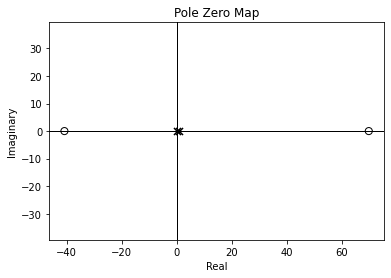

array([0.84919286+0.j, 0.09647055+0.j])

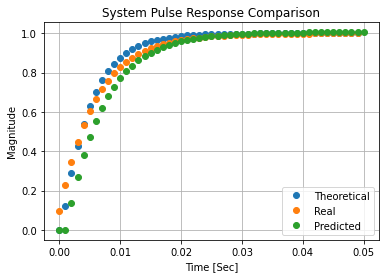

In [24]:
# Acomodamos Theta para obtener una función transferencia.
knum = np.array(Theta[order:].flatten())
den = [1, float(-Theta[0]), float(-Theta[1])]
rls_tf = tf(np.array(knum)[0], [[np.array(den)]], dt=1/SR_F_HZ)
ss_rls = tf2ss(rls_tf) 

# Observamos los polos y ceros
pzmap(ss_rls)
plt.show()

# Comparamos la respuesta al escalón con las anteriores
t_rls, hz_out_rls = step_response(ss_rls, T=0.05)
t, hz_out = step_response(hz_1)
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], hz_out[:SR_F_HZ//SQ_WAVE_F_HZ//2], 'o', label='Theoretical')
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o', label='Real')
plt.plot(t_rls, hz_out_rls, 'o', label='Predicted')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

poles(ss_rls)